# Compute $\Delta T$

### Imports


In [1]:
import pandas as pd
import xarray as xr
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


### General about computing $\Delta T$:

We compute the change in GSAT temperature ($\Delta T$) from the effective radiative forcing (ERF) from MAGICC?????? (#TODO: check model and reference), by integrating with the impulse response function (IRF(t-t'))

#todo: check for ref for IRF
(Geoffroy at al 2013).

For any forcing agent $x$, with estimated ERF$_x$, the change in temperature $\Delta T$ is calculated as:


\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are shown below. 

**TODO: find ref**

## Input data:
See [README.md](../../README.md)

# Code + figures

In [2]:
#fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2020_12_02_050025-1.csv'
#fn_IRF_constants = INPUT_DATA_DIR / 'irf_from_2xCO2_2021_02_02_025721.csv'
#fn_IRF_constants = INPUT_DATA_DIR / 'recommended_irf_from_2xCO2_2021_02_03_045947.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'recommended_irf_from_2xCO2_2021_02_07_223156.csv'
fn_IRF_constants = INPUT_DATA_DIR / 'recommended_irf_from_2xCO2_2021_02_17_233041.csv'

irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.786045,149.789917,1.333333,1.027856,0.896322,3.424102,285.003478,0.436002,0.313998,1.027856,3.0,1.801052,4.0


In [3]:
irf_consts['d1 (yr)']=10.

In [4]:
# lets get the irf values from 0 until i
d1 = 10.#float(irf_consts[ld1])
d2 = float(irf_consts[ld2])
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])

print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=10.0, d2=285.00347784191143, q1=0.4360017936279869, q2=0.31399820637201514


### Path input data

In [5]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR / 'ERF_data.nc'
PATH_DATASET = OUTPUT_DATA_DIR/'historic_delta_GSAT/hist_ERF_est.csv'



## Path output data

In [6]:
#PATH_DT_TAB_OUTPUT = RESULTS_DIR / 'tables' / 'table_sens_dT_cs_recommandetion.csv'
PATH_DF_OUTPUT = OUTPUT_DATA_DIR / 'historic_delta_GSAT/dT_data_hist_recommendation.csv'

print(PATH_DF_OUTPUT)

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/historic_delta_GSAT/dT_data_hist_recommendation.csv


## various definitions

In [7]:
# name of output variable
name_deltaT = 'Delta T'

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

## Set values:

We only compute for the recommendation (not e.g. percentiles):

In [8]:
IRFpercentiles = [recommendation]
# {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }

Year to integrate from and to:

In [9]:
first_y = 1750
last_y = 2020

**Set reference year for temperature change:**

In [10]:
ref_year = 1750

### Define variables to look at:

In [11]:
# variables to plot:
variables_erf_comp = [
    'CO2', 'N2O', 'CH4', 'HC', 'NOx', 'SO2', 'BC', 'OC', 'NH3'
]
# total ERFs for anthropogenic and total:
variables_erf_tot = []
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = []

## IRF function: 

In [12]:

def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

### Open ERF dataset:

In [13]:
df = pd.read_csv(PATH_DATASET, index_col=0)
da_ERF = df.to_xarray().to_array()#'variable'
da_ERF = da_ERF.rename({'index':'year'})
#ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
ds = xr.Dataset({'ERF':da_ERF})
ds
#da_ERF = ds['ERF']

<xarray.Dataset>
Dimensions:   (variable: 10, year: 270)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) <U3 'CO2' 'N2O' 'CH4' 'NOx' ... 'OC' 'NH3' 'VOC' 'HC'
Data variables:
    ERF       (variable, year) float64 0.0 0.001126 0.002252 ... 0.2058 0.2071

#### Simple pre-processing

In [14]:
ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')

# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})
ds

<xarray.Dataset>
Dimensions:   (variable: 10, year: 270)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) <U3 'CO2' 'N2O' 'CH4' 'NOx' ... 'OC' 'NH3' 'VOC' 'HC'
Data variables:
    ERF       (variable, year) float64 0.0 0.001126 0.002252 ... 0.2058 0.2071
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

## Integrate and compute $\Delta T$:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

In [15]:


def integrate_(i, _var, _nvar, ds_in: xr.Dataset, ds_DT, irf_cnst: dict):
    """

    :param i:
    :param _var:
    :param _nvar:
    :param ds_in:
    :param ds_DT:
    :param irf_cnst: dictionary
    :return:
    """
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
    #print(ds_short)
    # lets get the current year
    current_year = ds_short['year'][{'year': i}]  # .dt.year
    # lets get a list of years
    _years = ds_short['year']  # .dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - _years

    # lets get the irf values from 0 until i
    d1 = irf_cnst[ld1]
    d2 = irf_cnst[ld2]
    q1 = irf_cnst[lq1]
    q2 = irf_cnst[lq2]

    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], d1, q1, d2, q2)

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[_var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['year'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(year=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[_nvar][{'year': i}] = _val


def integrate_to_dT(_ds, from_t, to_t, irf_cnsts, int_var='ERF'):
    """
    Integrate forcing to temperature change.

    :param _ds: dataset containing the forcings
    :param from_t: start year
    :param to_t: end year
    :param int_var: variables to integrate
    :param irf_cnsts: irf constants
    :return:
    """
    # slice dataset
    ds_sl = _ds.sel(year=slice(from_t, to_t))
    len_time = len(ds_sl['year'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    namevar = name_deltaT
    # set all values to zero for results dataarray:
    ds_DT[namevar] = ds_DT[int_var] * 0
    # Units Kelvin:
    ds_DT[namevar].attrs['unit'] = 'K'
    if 'unit' in ds_DT[namevar].coords:
        ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        integrate_(i, int_var, namevar, ds_sl, ds_DT, irf_cnsts)
    clear_output()
    # fn = 'DT_%s-%s.nc' % (from_t, to_t)
    #fname = OUTPUT_DATA_DIR/ fn#'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    #ds_DT.to_netcdf(fname)
    return ds_DT

In [16]:
dic_ds = {}
for key in IRFpercentiles:
    dic_ds[key] = integrate_to_dT(ds, first_y, last_y, irf_consts.loc[key], int_var='ERF')

## check:

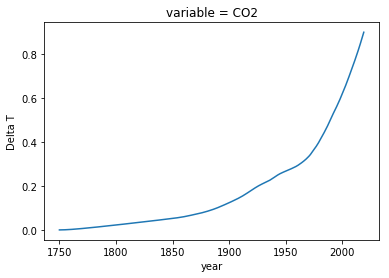

In [17]:
for per in IRFpercentiles:
    dic_ds[per].isel( variable=0)[name_deltaT].plot()

### Make datset with percentile as dimension:
Does really only make sense with percentiles...

In [18]:
ds_tmp = xr.Dataset(coords=dic_ds[recommendation].coords)
ds_tmp
for key in IRFpercentiles:
    ds_tmp[key] = dic_ds[key]['Delta T']  # .dims,dic_ds[key],)
ds['Delta T'] = ds_tmp.to_array('percentile')

In [19]:
ds

<xarray.Dataset>
Dimensions:     (percentile: 1, variable: 10, year: 270)
Coordinates:
  * year        (year) int64 1750 1751 1752 1753 1754 ... 2016 2017 2018 2019
  * variable    (variable) <U3 'CO2' 'N2O' 'CH4' 'NOx' ... 'OC' 'NH3' 'VOC' 'HC'
  * percentile  (percentile) <U14 'recommendation'
Data variables:
    ERF         (variable, year) float64 0.0 0.001126 0.002252 ... 0.2058 0.2071
    time        (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t     (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Delta T     (percentile, variable, year) float64 0.0 5.034e-05 ... 0.09651

# Save dataset:

In [20]:
ds.sel(year=slice(first_y, last_y)).to_netcdf(PATH_DF_OUTPUT.with_suffix('.nc'))
print(f'Saved to ')
print(PATH_DF_OUTPUT.with_suffix('.nc'))
# ds_DT.to_array('percentile')
# dic_ds[key]['Delta T']

Saved to 
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/historic_delta_GSAT/dT_data_hist_recommendation.nc


In [21]:
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic

<IPython.core.display.Javascript object>

hallo


In [22]:
cols = get_cmap_dic(variables_all)

(0.9568627450980393, 0.796078431372549, 0.21176470588235294)
(0.8274509803921568, 0.0, 0.1568627450980392)
(1.0, 0.4196078431372549, 0.07450980392156863)
(0.47843137254901963, 0.5058823529411764, 0.5058823529411764)
(0.26666666666666666, 0.0, 0.5254901960784314)
(0.3764705882352941, 0.5725490196078431, 0.796078431372549)
(0.5411764705882353, 0.2235294117647059, 0.0)
(0.4745098039215686, 0.792156862745098, 0.9333333333333333)
(0.0, 0.6901960784313725, 0.6039215686274509)


In [23]:
df_deltaT = ds[name_deltaT].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

In [24]:
df_deltaT.to_csv(PATH_DF_OUTPUT)

Text(0,0.5,'$\\Delta$ T ($^\\circ$ C)')

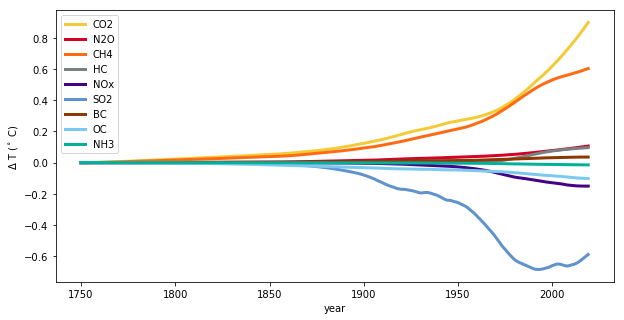

In [25]:
fig, ax = plt.subplots(figsize=[10,5])
for v in variables_all:
    df_deltaT[variables_all][v].plot(linewidth=3,ax = ax, label=v, color=cols[v])#, color=cols.items())
plt.legend(loc='upper left')
plt.ylabel('$\Delta$ T ($^\circ$ C)')

Text(0,0.5,'$\\Delta$ T ($^\\circ$ C)')

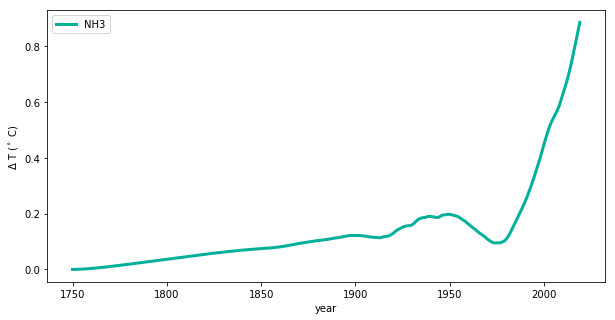

In [26]:
df_deltaT = ds[name_deltaT].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']
fig, ax = plt.subplots(figsize=[10,5])
df_deltaT[variables_all].sum(axis=1).plot(linewidth=3,ax = ax, label=v, color=cols[v])#, color=cols.items())
plt.legend(loc='upper left')
plt.ylabel('$\Delta$ T ($^\circ$ C)')

Text(0,0.5,'$\\Delta$ T ($^\\circ$ C)')

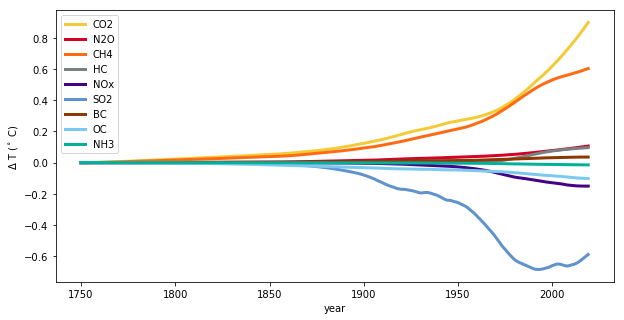

In [27]:
df_deltaT = ds[name_deltaT].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']
fig, ax = plt.subplots(figsize=[10,5])
for v in variables_all:
    df_deltaT[variables_all][v].plot(linewidth=3,ax = ax, label=v, color=cols[v])#, color=cols.items())
plt.legend(loc='upper left')
plt.ylabel('$\Delta$ T ($^\circ$ C)')

Text(0,0.5,'$\\Delta$ T ($^\\circ$ C)')

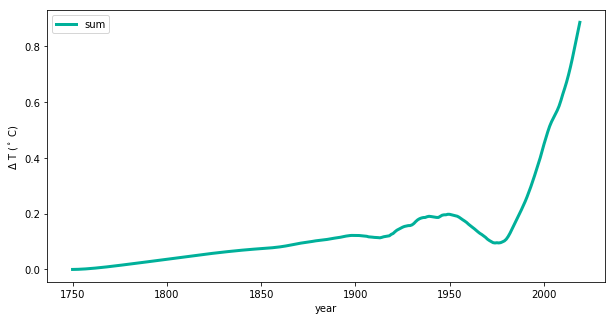

In [28]:
df_deltaT = ds[name_deltaT].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']
fig, ax = plt.subplots(figsize=[10,5])
df_deltaT[variables_all].sum(axis=1).plot(linewidth=3,ax = ax, label='sum', color=cols[v])#, color=cols.items())
plt.legend(loc='upper left')
plt.ylabel('$\Delta$ T ($^\circ$ C)')

In [29]:
df_deltaT

variable,BC,CH4,CO2,HC,N2O,NH3,NOx,OC,SO2,VOC
year,,,,,,,,,,
1750,0.000000e+00,0.000000,0.000000,2.243148e-09,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
1751,6.626252e-07,0.000037,0.000050,4.277899e-09,0.000003,-2.136839e-07,-5.235626e-08,-0.000005,-0.000002,0.000008
1752,1.926800e-06,0.000108,0.000146,6.124068e-09,0.000010,-6.211678e-07,-1.526162e-07,-0.000015,-0.000006,0.000023
1753,3.734920e-06,0.000209,0.000284,7.799582e-09,0.000019,-1.204458e-06,-2.958565e-07,-0.000029,-0.000011,0.000045
1754,6.037191e-06,0.000339,0.000459,9.320665e-09,0.000031,-1.947271e-06,-4.785158e-07,-0.000047,-0.000017,0.000072
...,...,...,...,...,...,...,...,...,...,...
2015,3.575755e-02,0.587115,0.832016,9.297039e-02,0.099701,-1.388914e-02,-1.502375e-01,-0.099816,-0.628068,0.274266
2016,3.577325e-02,0.591179,0.848826,9.385386e-02,0.101371,-1.405382e-02,-1.504074e-01,-0.100486,-0.618319,0.272574
2017,3.579069e-02,0.595284,0.865704,9.473536e-02,0.103058,-1.422069e-02,-1.505696e-01,-0.101110,-0.608039,0.270774


Text(0,0.5,'$\\Delta$ T ($^\\circ$ C)')

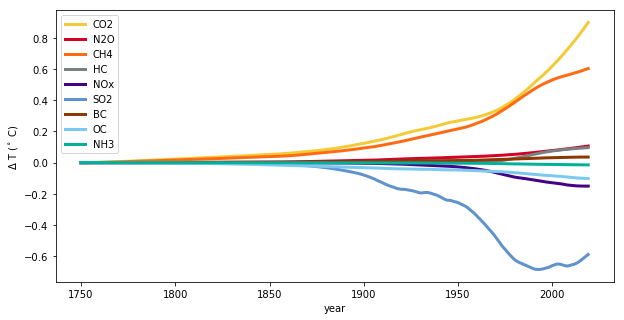

In [30]:
df_deltaT = ds[name_deltaT].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']
fig, ax = plt.subplots(figsize=[10,5])
for v in variables_all:
    df_deltaT[variables_all][v].plot(linewidth=3,ax = ax, label=v, color=cols[v])#, color=cols.items())
plt.legend(loc='upper left')
plt.ylabel('$\Delta$ T ($^\circ$ C)')